### Notebook 11 — Alternative Router Model (XGBoost) Training and Comparison

This notebook trains an **additional router model** using **XGBoost** (different from the Random Forest router in Notebook 5) while keeping the workflow **apples-to-apples**:
- same model capability profiles (Notebook 4 output)
- same synthetic request generation style
- same feasibility constraints and cost-minimization labeling policy

It produces evaluation metrics plus **report-ready plots** (confusion matrix, feature importance, and cost/SLA comparison).


### Environment setup and dependency checks


In [2]:
!conda install -y -c conda-forge xgboost
!{sys.executable} -m pip -q install s3fs

Retrieving notices: done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.11.0
    latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libxgboost-3.2.0           |   cpu_h2ebb00f_0         3.8 MB  conda-forge
    numpy-2.4.2                |  py312h33ff503_1         8.4 MB  conda-forge
    py-xgboost-3.2.0           | cpu_pyh718b53a_0         168 KB  conda-forge
    xgboost-3.2.0              | cpu_pyhb39878e_0          16 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        12.3 MB

Th

In [3]:
import xgboost as xgb
print("xgboost version:", xgb.__version__)

xgboost version: 3.2.0


In [4]:
import numpy as np
import pandas as pd
import boto3
import sagemaker

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

Unable to load JumpStart region config.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/constants.py", line 69, in _load_region_config
    with open(filepath) as f:
         ^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/region_config.json'


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Locate inputs in S3 (model profiles from Notebook 4)


In [5]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name

print("Region:", region)
print("Bucket:", bucket)

Region: us-east-1
Bucket: sagemaker-us-east-1-907086662522


In [6]:
profiles_key = "processed/model_profiles.csv"
profiles_s3 = f"s3://{bucket}/{profiles_key}"

s3 = boto3.client("s3")
try:
    s3.head_object(Bucket=bucket, Key=profiles_key)
    print("✅ Found:", profiles_s3)
except Exception as e:
    raise FileNotFoundError(
        f"model_profiles.csv not found at {profiles_s3}. "
        "Run Notebook 4 (model profiles) first."
    ) from e


✅ Found: s3://sagemaker-us-east-1-907086662522/processed/model_profiles.csv


In [7]:
profiles = pd.read_csv(profiles_s3)
print("profiles shape:", profiles.shape)
display(profiles.head(5))

profiles shape: (17, 9)


/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/fsspec/registry.py:301: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,Model,quality_score_mean,quality_score_max,achievements_count,domains_count,peer_reviewed_rate,outperforms_rate,domains_covered,quality_tier
0,Gemini 3,4.476880,4.476880,1,1,0.0,1.0,Transcription,5
1,Claude 3.6S,4.415792,4.415792,1,1,0.0,1.0,Persuasion,5
2,o3-mini-high,4.360643,4.360643,1,1,0.0,1.0,Health reviews,5
3,o1,4.040036,4.500000,2,2,0.0,1.0,"Maths, Medicine",5
4,"GPT-4, etc",3.694612,3.694612,1,1,0.0,1.0,Emotional intelligence,4


### Standardize required fields and add simulated operational characteristics

In [8]:
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

col_model = pick_col(profiles, ["Model", "model", "model_name"])
col_tier  = pick_col(profiles, ["tier", "Tier", "quality_tier", "performance_tier"])
col_score = pick_col(profiles, ["quality_score_mean", "quality_score", "mean_quality_score", "score_mean"])

if col_model is None:
    raise ValueError("Could not find a model name column in model_profiles.csv")

work = profiles.copy().rename(columns={col_model: "model"})

# Ensure a tier exists (either use existing or derive from score)
if col_tier is not None:
    work = work.rename(columns={col_tier: "tier"})
else:
    if col_score is None:
        work["tier"] = "mid"
    else:
        work = work.rename(columns={col_score: "score"})
        work["tier"] = pd.qcut(work["score"].rank(method="first"), q=3, labels=["low","mid","high"]).astype(str)

work = work.drop_duplicates(subset=["model"]).reset_index(drop=True)

print("Unique models:", len(work))
display(work[["model","tier"]].head(10))


Unique models: 17


,model,tier
0,Gemini 3,5
1,Claude 3.6S,5
2,o3-mini-high,5
3,o1,5
4,"GPT-4, etc",4
5,o4-mini,4
6,davinci,4
7,Bing Chat,3
8,GPT-4.5,3
9,GPT-4,3


In [9]:
rng = np.random.default_rng(42)

tier_rank = {"low": 0, "mid": 1, "high": 2}
tier_params = {
    "low":  {"cost_in": (0.10, 0.30), "cost_out": (0.15, 0.45), "base_lat": (0.25, 0.60), "lat_per_tok": (0.0008, 0.0018)},
    "mid":  {"cost_in": (0.30, 0.90), "cost_out": (0.45, 1.35), "base_lat": (0.35, 0.85), "lat_per_tok": (0.0012, 0.0025)},
    "high": {"cost_in": (0.90, 3.00), "cost_out": (1.35, 4.50), "base_lat": (0.45, 1.10), "lat_per_tok": (0.0018, 0.0035)},
}

def sample_range(lo, hi, size):
    return rng.uniform(lo, hi, size=size)

tiers = work["tier"].astype(str).str.lower().fillna("mid")
tiers = tiers.replace({"medium":"mid","med":"mid","top":"high","best":"high","bottom":"low"})
work["tier_norm"] = tiers.where(tiers.isin(["low","mid","high"]), "mid")

work["cost_per_1k_in"]  = np.nan
work["cost_per_1k_out"] = np.nan
work["base_latency_s"]  = np.nan
work["latency_per_tok_s"] = np.nan

for t in ["low","mid","high"]:
    idx = work["tier_norm"] == t
    n = int(idx.sum())
    if n == 0:
        continue
    p = tier_params[t]
    work.loc[idx, "cost_per_1k_in"]  = sample_range(*p["cost_in"], size=n)
    work.loc[idx, "cost_per_1k_out"] = sample_range(*p["cost_out"], size=n)
    work.loc[idx, "base_latency_s"]  = sample_range(*p["base_lat"], size=n)
    work.loc[idx, "latency_per_tok_s"] = sample_range(*p["lat_per_tok"], size=n)

models = work.reset_index(drop=True)
display(models.head(5))


,model,quality_score_mean,quality_score_max,achievements_count,domains_count,peer_reviewed_rate,outperforms_rate,domains_covered,tier,tier_norm,cost_per_1k_in,cost_per_1k_out,base_latency_s,latency_per_tok_s
0,Gemini 3,4.476880,4.476880,1,1,0.0,1.0,Transcription,5,mid,0.764374,0.507436,0.584778,0.001210
1,Claude 3.6S,4.415792,4.415792,1,1,0.0,1.0,Persuasion,5,mid,0.563327,1.194868,0.444736,0.002223
2,o3-mini-high,4.360643,4.360643,1,1,0.0,1.0,Health reviews,5,mid,0.815159,1.018498,0.414961,0.002064
3,o1,4.040036,4.500000,2,2,0.0,1.0,"Maths, Medicine",5,mid,0.718421,1.132279,0.587852,0.002117
4,"GPT-4, etc",3.694612,3.694612,1,1,0.0,1.0,Emotional intelligence,4,mid,0.356506,0.769073,0.463455,0.002215


### Generate synthetic request workload (same style as Notebook 5)


In [10]:
rng = np.random.default_rng(123)
N = 20000

requests = pd.DataFrame({
    "prompt_tokens": rng.integers(50, 6000, size=N),
    "output_tokens": rng.integers(50, 2000, size=N),
})

requests["latency_budget_s"] = rng.choice([0.8, 1.2, 2.0, 3.5, 5.0], size=N, p=[0.15, 0.25, 0.30, 0.20, 0.10])
requests["min_tier"] = rng.choice(["low","mid","high"], size=N, p=[0.25, 0.55, 0.20])

display(requests.head())

,prompt_tokens,output_tokens,latency_budget_s,min_tier
0,141,1946,1.2,low
1,4109,1718,3.5,mid
2,3578,485,0.8,low
3,370,1079,2.0,high
4,5459,600,2.0,mid


### Define feasibility checks and the optimal (label) policy


In [11]:
def feasible(model_row, req_row):
    # quality feasibility
    if tier_rank.get(model_row["tier_norm"], 1) < tier_rank.get(req_row["min_tier"], 1):
        return False
    # latency feasibility
    total_tokens = int(req_row["prompt_tokens"] + req_row["output_tokens"])
    est_latency = float(model_row["base_latency_s"] + model_row["latency_per_tok_s"] * total_tokens)
    return est_latency <= float(req_row["latency_budget_s"])

def est_cost(model_row, req_row):
    return (req_row["prompt_tokens"]/1000.0) * model_row["cost_per_1k_in"] + (req_row["output_tokens"]/1000.0) * model_row["cost_per_1k_out"]

labels, opt_cost, opt_latency, feas_ct = [], [], [], []

# cost-minimum among feasible models; best-effort fallback if none feasible
for _, r in requests.iterrows():
    best_m = None
    best_c = None
    count = 0
    for _, m in models.iterrows():
        if feasible(m, r):
            count += 1
            c = float(est_cost(m, r))
            if best_c is None or c < best_c:
                best_c = c
                best_m = m
    feas_ct.append(count)
    if best_m is None:
        # best effort: highest tier model
        best_m = models.sort_values(["tier_norm"], key=lambda s: s.map(tier_rank)).iloc[-1]
        best_c = float(est_cost(best_m, r))

    labels.append(best_m["model"])
    opt_cost.append(best_c)

    total_tokens = int(r["prompt_tokens"] + r["output_tokens"])
    opt_latency.append(float(best_m["base_latency_s"] + best_m["latency_per_tok_s"] * total_tokens))

requests["label_model"] = labels
requests["opt_cost"] = opt_cost
requests["opt_latency_s"] = opt_latency
requests["feasible_models"] = feas_ct

display(requests.head())


,prompt_tokens,output_tokens,latency_budget_s,min_tier,label_model,opt_cost,opt_latency_s,feasible_models
0,141,1946,1.2,low,NaN,1.613741,3.779001,0
1,4109,1718,3.5,mid,NaN,3.945878,9.744806,0
2,3578,485,0.8,low,NaN,2.643938,6.930988,0
3,370,1079,2.0,high,NaN,1.079421,2.761305,0
4,5459,600,2.0,mid,NaN,3.924235,10.114878,0


### Build training features


In [13]:
# ======================================================
# Sanitize data and build training features
# ======================================================

# --- sanitize tier + labels to avoid NaNs ---
requests["min_tier"] = requests["min_tier"].astype(str).str.strip().str.lower()

# map tiers; anything unknown becomes 'mid'
requests.loc[~requests["min_tier"].isin(tier_rank.keys()), "min_tier"] = "mid"

# ensure label exists
requests["label_model"] = requests["label_model"].astype(str).replace({"nan": np.nan})

# --- build features ---
X = requests[["prompt_tokens", "output_tokens", "latency_budget_s"]].copy()
X["min_tier_rank"] = requests["min_tier"].map(tier_rank).astype(int)

y = requests["label_model"]

# --- drop rows with any NaN ---
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print("Dropped rows due to NaN:", (~mask).sum())
print("Remaining rows:", len(y), "Unique classes:", y.nunique())

# --- split ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- encode labels ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Classes:", len(le.classes_))

Dropped rows due to NaN: 18261
Remaining rows: 1739 Unique classes: 5
Train: (1304, 4) Test: (435, 4)
Classes: 5


### Train XGBoost router model


In [14]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective="multi:softprob",
    n_estimators=350,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

xgb_model.fit(X_train, y_train_enc)

pred_enc = xgb_model.predict(X_test)
pred = le.inverse_transform(pred_enc)

acc = accuracy_score(y_test, pred)
print("✅ XGBoost router accuracy:", round(acc, 4))
print()
print(classification_report(y_test, pred, zero_division=0))


✅ XGBoost router accuracy: 0.9034

                                         precision    recall  f1-score   support

                             GPT-4, etc       1.00      0.70      0.82        10
                                GPT-4.5       0.91      0.92      0.92       216
                               Gemini 3       0.88      0.92      0.90       128
https://lifearchitect.ai/iq-testing-ai/       0.00      0.00      0.00         1
                       text-davinci-003       0.91      0.86      0.88        80

                               accuracy                           0.90       435
                              macro avg       0.74      0.68      0.71       435
                           weighted avg       0.90      0.90      0.90       435



### Report-ready plots


### Confusion matrix (top classes only for readability)


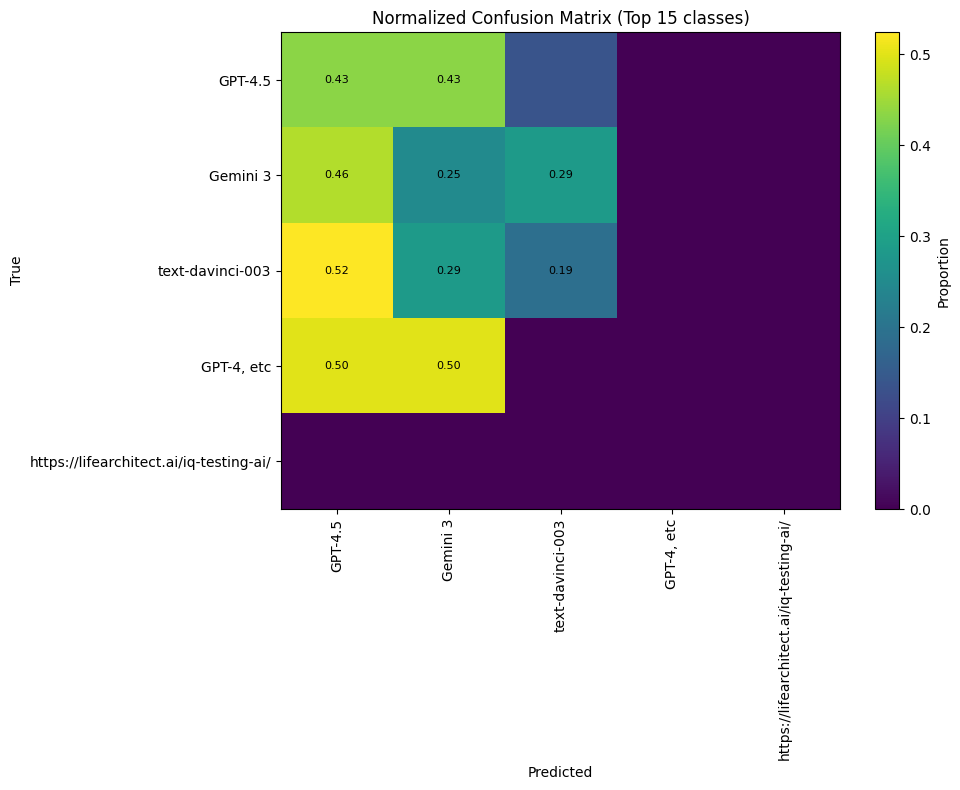

In [20]:
# Confusion matrix can be huge → show top-K most frequent classes, normalized
K = 15
top_classes = pd.Series(y_test).value_counts().head(K).index.tolist()

mask = pd.Series(y_test).isin(top_classes) & pd.Series(pred).isin(top_classes)
y_true_k = pd.Series(y_test)[mask]
y_pred_k = pd.Series(pred)[mask]

labels_k = top_classes
cm = confusion_matrix(y_true_k, y_pred_k, labels=labels_k)

# Normalize by true class counts (row-wise)
cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm, aspect="auto")
plt.title(f"Normalized Confusion Matrix (Top {K} classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(labels_k)), labels_k, rotation=90)
plt.yticks(range(len(labels_k)), labels_k)
plt.colorbar(label="Proportion")

# Optional: annotate cells (only if you want numbers)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        if val >= 0.15:  # avoid clutter
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

### Feature importance (XGBoost)


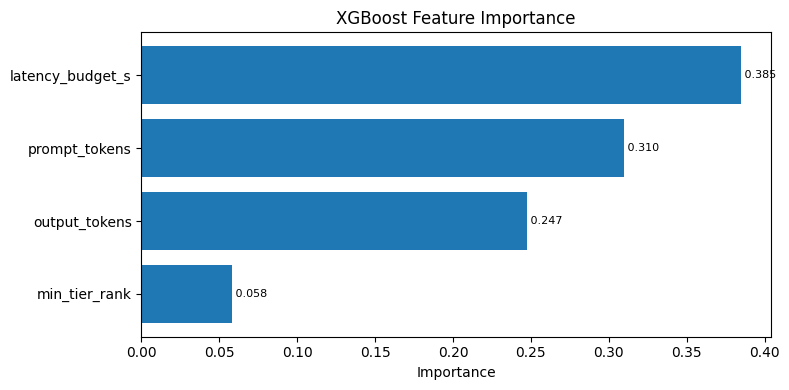

In [21]:
importances = xgb_model.feature_importances_
feat_names = X_train.columns.tolist()

fi = pd.Series(importances, index=feat_names).sort_values(ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(fi.index, fi.values)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")

# value labels
for i, v in enumerate(fi.values):
    plt.text(v, i, f" {v:.3f}", va="center", fontsize=8)

plt.tight_layout()
plt.show()

### Save results to S3 


In [19]:
out_key = "processed/router_alt_xgboost_results.csv"
out_s3  = f"s3://{bucket}/{out_key}"

tmp = "/tmp/router_alt_xgboost_results.csv"
results.to_csv(tmp, index=False)

!aws s3 cp {tmp} {out_s3}
print("✅ Saved:", out_s3)

upload: ../../../../tmp/router_alt_xgboost_results.csv to s3://sagemaker-us-east-1-907086662522/processed/router_alt_xgboost_results.csv
✅ Saved: s3://sagemaker-us-east-1-907086662522/processed/router_alt_xgboost_results.csv


## Summary

This notebook trained an **alternative cost-aware router** using **XGBoost** under the same data and labeling setup as the original router.

It reports classification performance and compares routing outcomes (cost and SLA satisfaction) against baseline strategies. The confusion matrix, feature importance, and policy comparison plots are designed to be copied directly into the final report.
